# Analisi Avanzata: Curve ROC vs Precision-Recall in Scenari Diversi
**Professore:** Gemini AI

In questo laboratorio avanzato, non ci limiteremo a un solo modello. Creeremo quattro situazioni diverse modificando i dati e l'architettura della rete neurale per capire come le curve **ROC (Receiver Operating Characteristic)** e **PR (Precision-Recall)** reagiscono a diversi problemi:

1.  **Baseline:** Un buon modello su dati bilanciati.
2.  **Random:** Un modello che tira a indovinare.
3.  **Overfitting:** Un modello che memorizza il training set ma fallisce sul test set.
4.  **Imbalanced:** Un modello su dati fortemente sbilanciati (la sfida più realistica).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras import layers, models

# --- FUNZIONI DI UTILITÀ ---

def get_data(n_samples=1000, weights=None, difficult=False):
    """Genera dati sintetici, opzionalmente sbilanciati o difficili."""
    sep = 0.5 if difficult else 1.0
    X, y = make_classification(n_samples=n_samples, n_features=10, n_informative=5, 
                               weights=weights, class_sep=sep, random_state=42)
    return train_test_split(X, y, test_size=0.3, random_state=42)

def build_and_train(X_train, y_train, model_type='normal', epochs=50):
    """Costruisce e addestra vari tipi di modelli Keras."""
    model = models.Sequential()
    if model_type == 'normal':
        model.add(layers.Dense(32, activation='relu', input_shape=(10,)))
        model.add(layers.Dense(16, activation='relu'))
    elif model_type == 'huge': # Per Overfitting
        model.add(layers.Dense(512, activation='relu', input_shape=(10,)))
        model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dense(256, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)
    return model

# Dizionario per salvare i risultati
results = {}

print("Setup completato. Funzioni pronte.")

Setup completato. Funzioni pronte.


c:\Users\mbagn\anaconda3\envs\pytorch\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


--- 
### Scenario 1: Baseline (Buon Modello)
Dati bilanciati (50/50), difficoltà media, modello di complessità adeguata.

In [2]:
X_train_B, X_test_B, y_train_B, y_test_B = get_data(weights=[0.5, 0.5], difficult=True)
model_B = build_and_train(X_train_B, y_train_B, model_type='normal', epochs=30)
probs_B = model_B.predict(X_test_B).ravel()
results['Baseline'] = (y_test_B, probs_B)
print("Scenario Baseline completato.")

c:\Users\mbagn\anaconda3\envs\pytorch\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Scenario Baseline completato.


--- 
### Scenario 2: Random Guessing (Modello Pessimo)
Simuliamo un modello che non ha imparato nulla generando probabilità casuali tra 0 e 1. Questo è il nostro "livello base" di performance.

In [3]:
# Usiamo gli stessi dati di test della baseline, ma generiamo predizioni casuali
y_test_R = y_test_B 
np.random.seed(42)
probs_R = np.random.rand(len(y_test_R))
results['Random'] = (y_test_R, probs_R)
print("Scenario Random completato.")

Scenario Random completato.


--- 
### Scenario 3: Overfitting Grave
Usiamo pochissimi dati di training e una rete neurale enorme. Il modello memorizzerà il training set ma non sarà in grado di generalizzare sul test set.

In [4]:
X_train_O, X_test_O, y_train_O, y_test_O = get_data(n_samples=150) # Pochi dati totali
# Addestriamo solo su 50 esempi con un modello enorme
model_O = build_and_train(X_train_O[:50], y_train_O[:50], model_type='huge', epochs=100)
probs_O = model_O.predict(X_test_O).ravel() # Valutiamo su dati che non ha mai visto
results['Overfitting'] = (y_test_O, probs_O)
print("Scenario Overfitting completato.")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Scenario Overfitting completato.


--- 
### Scenario 4: Dati Sbilanciati (Imbalanced)
La situazione più critica. Il 95% dei dati appartiene alla classe negativa (0) e solo il 5% alla classe positiva (1) che vogliamo trovare. Usiamo un modello normale.

In [5]:
# 95% classe 0, 5% classe 1
X_train_I, X_test_I, y_train_I, y_test_I = get_data(n_samples=2000, weights=[0.95, 0.05], difficult=True)
model_I = build_and_train(X_train_I, y_train_I, model_type='normal', epochs=50)
probs_I = model_I.predict(X_test_I).ravel()
results['Imbalanced'] = (y_test_I, probs_I)
print("Scenario Imbalanced completato.")
print(f"Frazione di positivi nel test set Imbalanced: {np.mean(y_test_I):.2%}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Scenario Imbalanced completato.
Frazione di positivi nel test set Imbalanced: 4.50%


--- 
### Visualizzazione e Confronto
Ora generiamo i grafici comparativi per i 4 scenari.

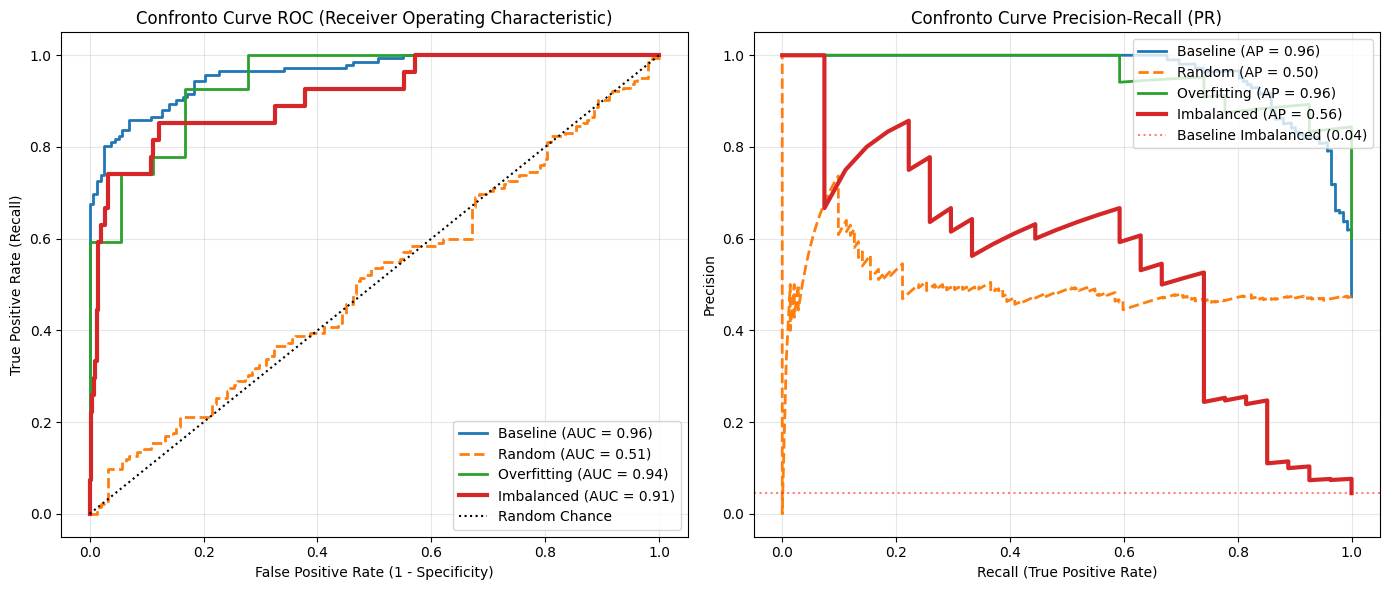

In [6]:
plt.figure(figsize=(14, 6))

# --- PLOT ROC CURVE ---
ax1 = plt.subplot(1, 2, 1)
for name, (y_test, probs) in results.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    linestyle = '--' if name == 'Random' else '-'
    linewidth = 3 if name == 'Imbalanced' else 2
    ax1.plot(fpr, tpr, linestyle=linestyle, linewidth=linewidth, label=f'{name} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], 'k:', label='Random Chance')
ax1.set_xlabel('False Positive Rate (1 - Specificity)')
ax1.set_ylabel('True Positive Rate (Recall)')
ax1.set_title('Confronto Curve ROC (Receiver Operating Characteristic)')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# --- PLOT PRECISION-RECALL CURVE ---
ax2 = plt.subplot(1, 2, 2)
for name, (y_test, probs) in results.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    # Calcoliamo la baseline per il PR plot (frazione di positivi)
    baseline = np.mean(y_test)
    linestyle = '--' if name == 'Random' else '-'
    linewidth = 3 if name == 'Imbalanced' else 2
    
    # Calcolo Average Precision (Area sotto la curva PR)
    ap = average_precision_score(y_test, probs)
    
    ax2.plot(recall, precision, linestyle=linestyle, linewidth=linewidth, label=f'{name} (AP = {ap:.2f})')
    if name == 'Imbalanced': # Mostriamo la baseline solo per il caso sbilanciato per chiarezza
        ax2.axhline(y=baseline, color='r', linestyle=':', alpha=0.5, label=f'Baseline Imbalanced ({baseline:.2f})')

ax2.set_xlabel('Recall (True Positive Rate)')
ax2.set_ylabel('Precision')
ax2.set_title('Confronto Curve Precision-Recall (PR)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Spiegazione Dettagliata dei Risultati

### 1. Curva ROC (Grafico a sinistra)
La ROC mette in relazione quanto siamo bravi a trovare i positivi (Recall/TPR) rispetto a quanti falsi allarmi generiamo (FPR).

* **Baseline (Linea Arancione):** Un buon modello si arcua verso l'angolo in alto a sinistra. Ha un alto AUC (es. > 0.85).
* **Random (Linea Blu tratteggiata):** Segue la diagonale. Significa che per ogni vero positivo che trovi, generi anche un falso positivo. AUC è circa 0.5.
* **Overfitting (Linea Verde):** Nonostante abbia memorizzato il training set, sul test set le sue probabilità sono quasi casuali o sbagliate con sicurezza. La curva è spesso vicina alla diagonale o peggio, con un AUC basso.
* **Imbalanced (Linea Rossa spessa):** **ATTENZIONE!** La curva ROC sembra buona (AUC alto, vicino alla baseline). Questo perché la ROC include i "Veri Negativi" nel calcolo del FPR. Essendo la maggior parte dei dati negativi (95%), il modello li azzecca facilmente, tenendo basso il FPR e gonfiando l'AUC. **La ROC è ottimistica sui dati sbilanciati.**

### 2. Curva Precision-Recall (Grafico a destra)
La PR si concentra solo sulla classe positiva: quanto siamo precisi quando prediciamo "positivo" e quanti positivi totali troviamo.

* **Baseline (Linea Arancione):** Parte con alta precisione e la mantiene per un buon tratto di Recall.
* **Random (Linea Blu tratteggiata):** È una linea orizzontale all'altezza della percentuale di positivi nel dataset (nel caso bilanciato, 0.5). Non importa la soglia, la tua precisione è solo la probabilità a priori.
* **Overfitting (Linea Verde):** Pessima performance. Spesso la precisione crolla immediatamente appena si cerca di aumentare la recall.
* **Imbalanced (Linea Rossa spessa):** **LA VERITÀ VIENE A GALLA.** Mentre la ROC sembrava buona, la curva PR mostra la realtà. La baseline qui è molto bassa (la linea rossa tratteggiata a 0.05). Il modello fatica enormemente a mantenere una buona precisione (asse Y) se vuole trovare molti positivi (asse X). L'area sotto questa curva (AP) è molto più bassa rispetto all'AUC della ROC. 

**Conclusione del Professore:** Quando avete dati sbilanciati (frodi, malattie rare), **non fidatevi mai solo della ROC AUC**. Usate sempre la curva Precision-Recall per capire se il vostro modello sta davvero trovando gli aghi nel pagliaio senza generare una montagna di falsi allarmi.